In [2]:
import math
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

In [8]:
import cv2
import numpy as np

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode

        self.df = pd.read_csv(csv_path)

        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]

        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        data = self.df.iloc[start:end]

        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)

    def get_data(self, data):
        batch_x = []
        batch_y = []

        for _, r in data.iterrows():
            file_name = r['file_name']
            
            try:
                image = cv2.imread(f'./images/{file_name}.jpg')
                if image is None:
                    raise ValueError(f"Image {file_name} not found.")
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (self.image_size, self.image_size))
                image = image / 255. 
            except Exception as e:
                print(f"Error loading image {file_name}: {e}")
                image = np.zeros((self.image_size, self.image_size, 3))  

            label = int(r['species']) - 1 

            batch_x.append(image)
            batch_y.append(label)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [9]:
csv_path = './kfolds.csv'
train_gererator = DataGenerator(batch_size=9, csv_path=csv_path, fold=1, image_size=256, mode='train', shuffle=True)
print(len(train_gererator) * 9)

5886


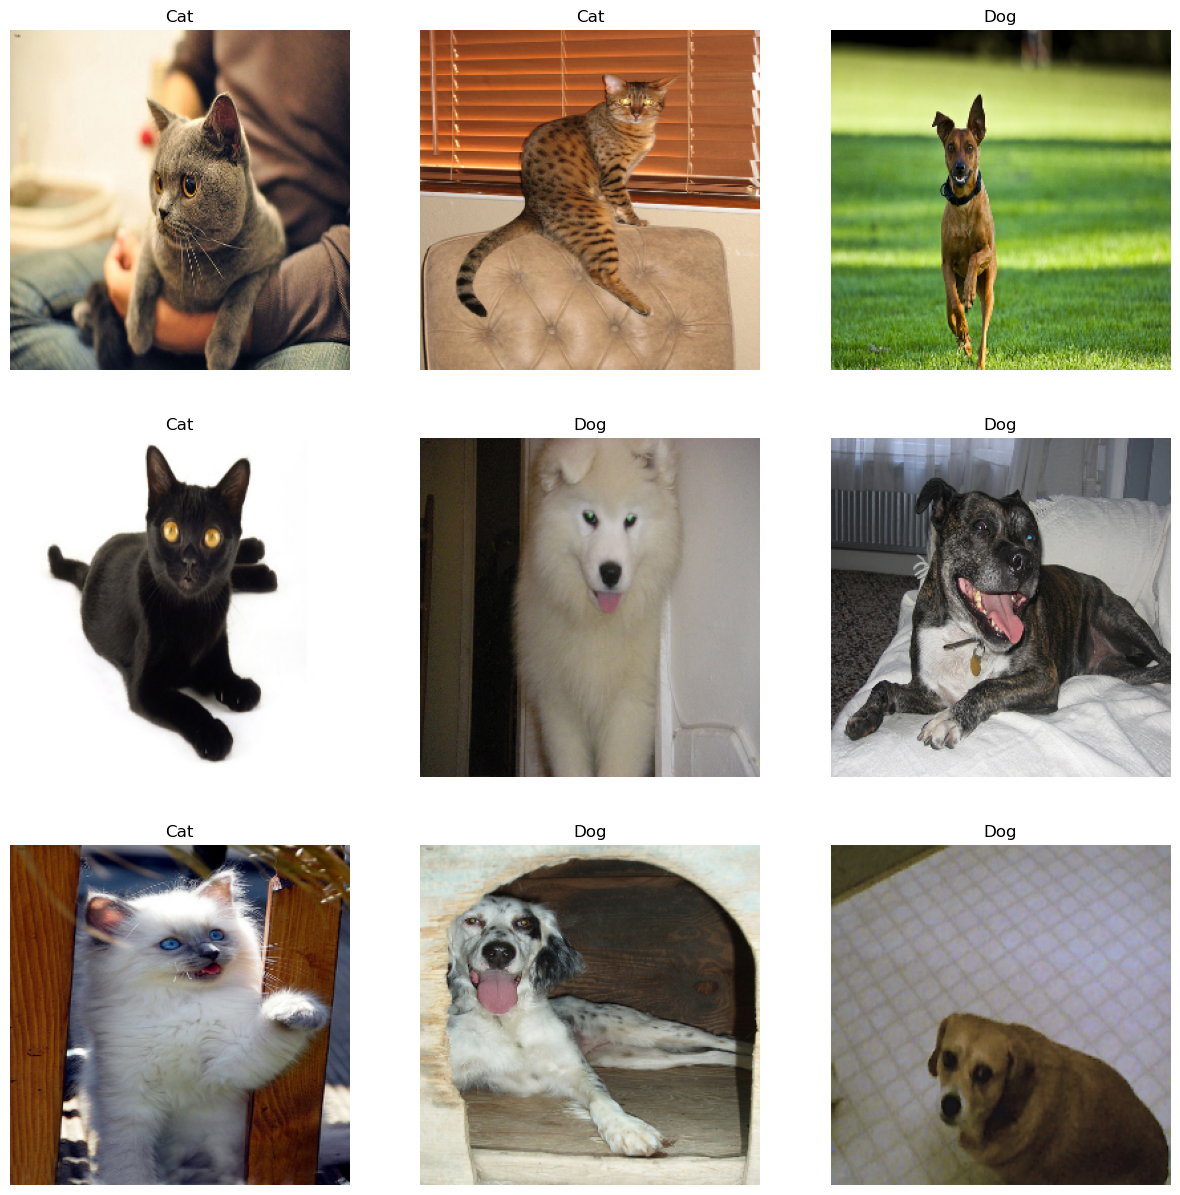

In [12]:
import matplotlib.pyplot as plt

class_names = ['Cat', 'Dog']

for batch in train_gererator:
    x, y = batch
    plt.figure(figsize=(15, 15))  
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(x[i]) 
        plt.title(class_names[int(y[i])])  
        plt.axis("off") 
    break  


In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

def get_sequential_model(input_shape):
    model = keras.Sequential(
        [   
            layers.Input(input_shape), 
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            layers.GlobalMaxPool2D(), 
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ]
    )
    return model

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,569 (1.06 MB)

 Trainable params: 277,185 (1.06 MB)

 Non-trainable params: 384 (1.50 KB)

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import cv2
import math
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size, fold, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
            
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'./images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255.0
            
            label = int(r['species']) - 1 
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [8]:
csv_path = './kfolds.csv'
train_gererator = DataGenerator(batch_size=128, csv_path=csv_path, image_size=256, fold=1, mode='train', shuffle=True)

valid_gererator = DataGenerator(batch_size=128, csv_path=csv_path   , image_size=256, fold=1, mode='val', shuffle=True)

In [10]:
history = model.fit(train_gererator, validation_data=valid_gererator, epochs=3, verbose=1)

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 2442s 53s/step - accuracy: 0.6432 - loss: 1.4705 - val_accuracy: 0.6776 - val_loss: 0.6351
Epoch 2/3
31/46 ━━━━━━━━━━━━━━━━━━━━ 18:56 76s/step - accuracy: 0.6718 - loss: 0.6237

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5)) 
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('eochs')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val') 
plt.legend()

plt.xlabel('eochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show()